In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [22]:
import torch.nn.functional as F
dropout_value = 0.15
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [23]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             120
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,512
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07927357405424118 Batch_id=468 Accuracy=85.37: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s] 



Test set: Average loss: 0.0733, Accuracy: 9802/10000 (98.02%)

EPOCH: 1


Loss=0.16061489284038544 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s] 



Test set: Average loss: 0.0519, Accuracy: 9848/10000 (98.48%)

EPOCH: 2


Loss=0.05744098126888275 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s] 



Test set: Average loss: 0.0481, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.09556970745325089 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s] 



Test set: Average loss: 0.0474, Accuracy: 9856/10000 (98.56%)

EPOCH: 4


Loss=0.044546693563461304 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]



Test set: Average loss: 0.0390, Accuracy: 9881/10000 (98.81%)

EPOCH: 5


Loss=0.11980553716421127 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s] 



Test set: Average loss: 0.0311, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.021568967029452324 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s] 



Test set: Average loss: 0.0403, Accuracy: 9873/10000 (98.73%)

EPOCH: 7


Loss=0.09312119334936142 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s] 



Test set: Average loss: 0.0309, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.04074610024690628 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s] 



Test set: Average loss: 0.0361, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


Loss=0.06242290511727333 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]  



Test set: Average loss: 0.0288, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.08458718657493591 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s] 



Test set: Average loss: 0.0337, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.004018397536128759 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s] 



Test set: Average loss: 0.0278, Accuracy: 9915/10000 (99.15%)

EPOCH: 12


Loss=0.02908491902053356 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]  



Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.015536289662122726 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s] 



Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.06978695839643478 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s] 



Test set: Average loss: 0.0299, Accuracy: 9911/10000 (99.11%)



In [27]:
import matplotlib.pyplot as plt

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

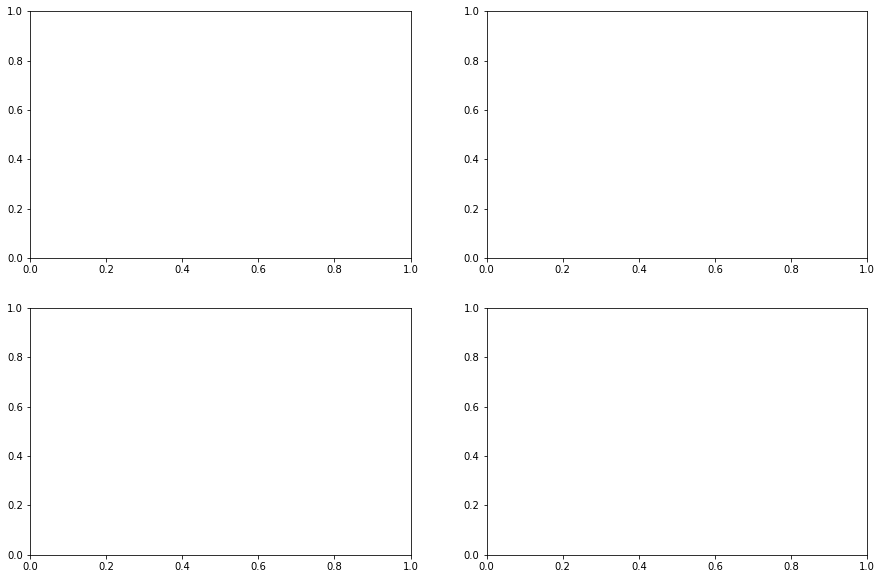

In [28]:
#%matplotlib inline
#import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")